In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime
from scipy.interpolate import interp1d

In [6]:
data_dir = '/home/musa/raspberrypi-recordings-cleaned/recordings-4-7-25'

In [7]:
dirs = [d for d in Path(data_dir).iterdir() if d.is_dir()]
dirs.sort(key=lambda x: x.stem.split('-')[1:])
dirs

[PosixPath('/home/musa/raspberrypi-recordings-cleaned/recordings-4-7-25/Musa-2025-03-24-22-30-31'),
 PosixPath('/home/musa/raspberrypi-recordings-cleaned/recordings-4-7-25/Musa-2025-03-24-22-35-09'),
 PosixPath('/home/musa/raspberrypi-recordings-cleaned/recordings-4-7-25/Musa-2025-03-24-22-40-14'),
 PosixPath('/home/musa/raspberrypi-recordings-cleaned/recordings-4-7-25/Musa-2025-03-24-22-46-49')]

In [75]:
d = dirs[0]

print(d.name)
df_emg = pd.read_csv(d / 'emg.csv')
df_imu = pd.read_csv(d / 'imu.csv')

print(df_emg.shape, df_imu.shape)

i=6
df_emg = df_emg.iloc[int(i*1000):]
df_imu = df_imu.iloc[int(i*100):]
print(df_emg.shape, df_imu.shape)

# df_emg.to_csv(d / 'emg.csv', index=False)
# df_imu.to_csv(d / 'imu.csv', index=False)


Aboud-2025-03-24-22-59-48
(41001, 2) (4101, 7)
(35001, 2) (3501, 7)


Musa-2025-03-24-22-30-31
(51501, 2) (5151, 7) {'name': 'Musa', 'age': 21, 'weight': 200, 'sex': 'M', 'location': 'Studio fit', 'machine_weight': 110, 'start_time': 1742869831.3271017, 'notes': '', 'end_rep_markers': [9.2, 14.2, 19, 24, 29.5, 36, 44.5, 54]}
Total reps: 8
Rep 1/8: 9.20 s
Rep 2/8: 5.00 s
Rep 3/8: 4.80 s
Rep 4/8: 5.00 s
Rep 5/8: 5.50 s
Rep 6/8: 6.50 s
Rep 7/8: 8.50 s
Rep 8/8: 9.50 s
(45791, 3) (4580, 8) {'name': 'Musa', 'age': 21, 'weight': 200, 'sex': 'M', 'location': 'Studio fit', 'machine_weight': 110, 'start_time': 1742869831.3271017, 'notes': '', 'end_rep_markers': [9.2, 14.2, 19, 24, 29.5, 36, 44.5, 54]}


Text(0.5, 0.98, 'Musa-2025-03-24-22-30-31')

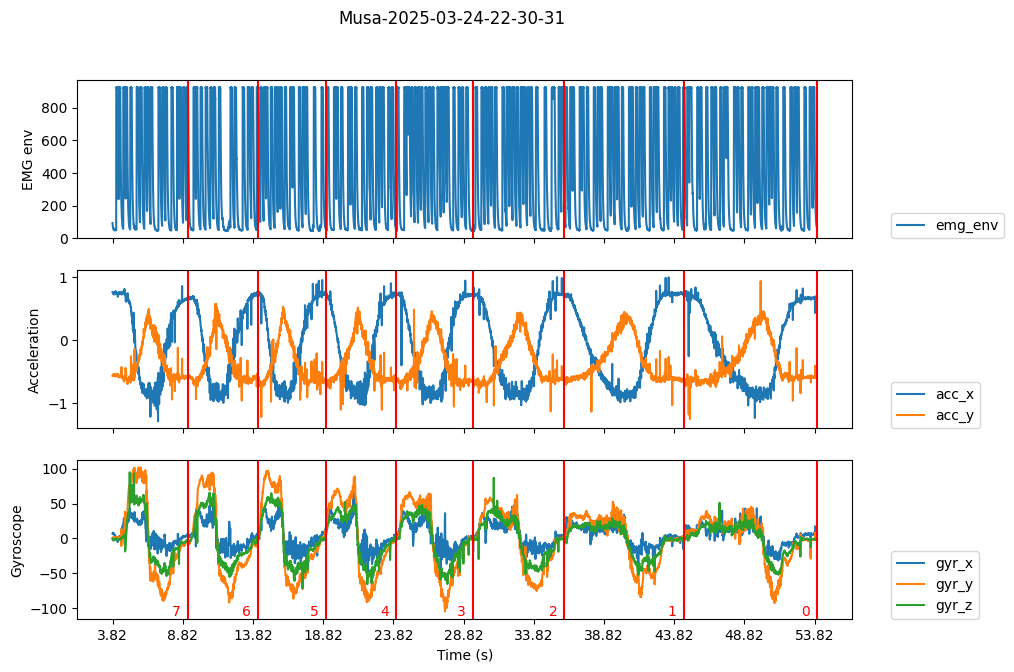

In [8]:
## FOR version 2 - emg.csv (1000 Hz) and imu.csv (100 Hz) - values not normalized
d = dirs[0]

print(d.name)
df_emg = pd.read_csv(d / 'emg.csv')
df_imu = pd.read_csv(d / 'imu.csv')
info = json.load(open(d / 'info.json'))
print(df_emg.shape, df_imu.shape, info)

total_reps = len(info['end_rep_markers'])
print('Total reps:', total_reps)
df_emg['rir'] = -1
df_imu['rir'] = -1
print(f'Rep 1/{total_reps}: {info["end_rep_markers"][0]:.2f} s')
df_emg.loc[df_emg['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
df_imu.loc[df_imu['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
    print(f'Rep {i+2}/{total_reps}: {end-start:.2f} s')
    df_emg.loc[df_emg['time'].between(start, end), 'rir'] = total_reps - i - 2
    df_imu.loc[df_imu['time'].between(start, end), 'rir'] = total_reps - i - 2
df_emg = df_emg[df_emg['rir'] != -1]
df_imu = df_imu[df_imu['rir'] != -1]

i=0
df_emg = df_emg.iloc[int(i*1000):]
df_imu = df_imu.iloc[int(i*100):]
print(df_emg.shape, df_imu.shape, info)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(df_emg['time'], df_emg['emg_env'], label='emg_env')
# axes[1].plot(df_imu['time'], df_imu[['acc_x', 'acc_y', 'acc_z']] / 16384.0, label=['acc_x', 'acc_y', 'acc_z'])
axes[1].plot(df_imu['time'], df_imu[['acc_x', 'acc_y']] / 16384.0, label=['acc_x', 'acc_y'])
axes[2].plot(df_imu['time'], df_imu[['gyr_x', 'gyr_y', 'gyr_z']] / 131.0, label=['gyr_x', 'gyr_y', 'gyr_z'])

axes[0].set_ylabel('EMG env')
axes[1].set_ylabel('Acceleration')
axes[2].set_ylabel('Gyroscope')
axes[2].set_xlabel('Time (s)')
[ax.legend(loc=(1.05, 0)) for ax in axes]

axes[2].set_xticks(np.arange(
    min(df_emg['time'].iloc[0], df_imu['time'].iloc[0]), 
    min(df_emg['time'].iloc[-1], df_imu['time'].iloc[-1]),
    5
))

for i,end_rep_mark in enumerate(info['end_rep_markers']):
    [ax.axvline(end_rep_mark, color='r') for ax in axes if end_rep_mark > df_emg['time'].iloc[0]]
    axes[2].text(end_rep_mark - 0.5, 0.02, total_reps - i - 1, transform=axes[2].get_xaxis_transform(), color='r', horizontalalignment='right')

plt.suptitle(d.stem)

In [ ]:
d = dirs[10]

df = pd.read_csv(d / 'data.csv')
i=.5

df = df.iloc[int(i*100):]
# df.to_csv(d / 'data.csv', index=False)

In [ ]:
## FOR version 1 - emg and imu in one file (data.csv) - values already normalized

d = dirs[11]

print(d.name)
df = pd.read_csv(d / 'data.csv')
df['emg_env']
info = json.load(open(d / 'info.json'))
print(df.shape, info)

total_reps = len(info['end_rep_markers'])
print('Total reps:', total_reps)
df['rir'] = -1
print(f'Rep 1/{total_reps}: {info["end_rep_markers"][0]:.2f} s')
df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
    print(f'Rep {i+2}/{total_reps}: {end-start:.2f} s')
    df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
df = df[df['rir'] != -1]

i=0
df = df.iloc[int(i*100):]
print(df.shape)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(df['time'], df['emg_env'], label='emg_env')
axes[1].plot(df['time'], df[['acc_x', 'acc_y']], label=['acc_x', 'acc_y'])
# axes[1].plot(df['time'], df[['acc_x', 'acc_y', 'acc_z']], label=['acc_x', 'acc_y', 'acc_z'])
axes[2].plot(df['time'], df[['gyr_x', 'gyr_y', 'gyr_z']], label=['gyr_x', 'gyr_y', 'gyr_z'])

axes[0].set_ylabel('EMG env')
axes[1].set_ylabel('Acceleration')
axes[2].set_ylabel('Gyroscope')
axes[2].set_xlabel('Time (s)')
[ax.legend(loc=(1.05, 0)) for ax in axes]

axes[2].set_xticks(np.arange(df['time'].iloc[0], df['time'].iloc[-1], 5))

for i,end_rep_mark in enumerate(info['end_rep_markers']):
    [ax.axvline(end_rep_mark, color='r') for ax in axes if end_rep_mark > df['time'].iloc[0]]
    axes[2].text(end_rep_mark - 0.5, 0.02, total_reps - i - 1, transform=axes[2].get_xaxis_transform(), color='r', horizontalalignment='right')

plt.suptitle(d.stem)

In [233]:
def interpolate_100hz(df):
    # Interpolate to 100Hz from current Hz
    t_100hz = np.arange(df.time.iloc[0], df.time.iloc[-1], 0.01)
    print(f'{1 / np.diff(df.time).mean():.02f} Hz ({df.shape[0]}) -> 100 Hz ({t_100hz.shape[0]})')
    df = pd.DataFrame(dict(
        time=t_100hz,
        acc_x=interp1d(df.time, df.acc_x, kind='cubic')(t_100hz),
        acc_y=interp1d(df.time, df.acc_y, kind='cubic')(t_100hz),
        acc_z=interp1d(df.time, df.acc_z, kind='cubic')(t_100hz),
        gyr_x=interp1d(df.time, df.gyr_x, kind='cubic')(t_100hz),
        gyr_y=interp1d(df.time, df.gyr_y, kind='cubic')(t_100hz),
        gyr_z=interp1d(df.time, df.gyr_z, kind='cubic')(t_100hz),
        rir=interp1d(  df.time, df.rir,   kind='nearest')(t_100hz),
    ))
    return df

def label_rir(df, info):
    total_reps = len(info['end_rep_markers'])
    df['rir'] = -1
    df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
    for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
        df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
    df = df[df['rir'] != -1]

In [235]:
data_dirs = [
    '/home/musa/raspberrypi-recordings-cleaned/recordings-3-07-25',
    '/home/musa/raspberrypi-recordings-cleaned/recordings-3-11-25',
    '/home/musa/raspberrypi-recordings-cleaned/recordings-3-15-25',
    '/home/musa/raspberrypi-recordings-cleaned/recordings-4-3-25',
    '/home/musa/raspberrypi-recordings-cleaned/recordings-4-7-25',
    '/home/musa/raspberrypi-recordings-cleaned/recordings-4-14-25',
    '/home/musa/raspberrypi-recordings-cleaned/recordings-4-15-25-strom',
    '/home/musa/raspberrypi-recordings-cleaned/recordings-4-16-25',
    '/home/musa/raspberrypi-recordings-cleaned/recordings-4-16-25-bluecross',
    '/home/musa/raspberrypi-recordings-cleaned/recordings-4-17-25-strom',
]

In [239]:
not_failure_each = [[],[4],[],[],[],[],[2],[],[0],[2]]
use_old = [True, True, True, False, False,False,False,False,False,False]
dfs =[]
outdir = Path('data/')
outdir.mkdir(exist_ok=True, parents=True)
session_id = 0
if len(use_old) != len(data_dirs):
    raise ValueError('Length of use_old must match length of data_dirs')
for data_dir, not_failure, use_oldi in zip(data_dirs, not_failure_each, use_old):
    dirs = [d for d in Path(data_dir).iterdir() if d.is_dir()]
    dirs.sort(key=lambda x: x.stem.split('-')[1:])
    for i in range(len(dirs)):
        d = dirs[i]
        failure = i not in not_failure
        name = d.name.split('-')[0]
        session = d.parent.name + '/' + d.name

        if use_oldi:
            df = pd.read_csv(d / 'data.csv').drop(columns=['emg_env'])
        else:
            df = pd.read_csv(d / 'imu.csv')
            df[['acc_x', 'acc_y', 'acc_z']] = df[['acc_x', 'acc_y', 'acc_z']] / 16384.0
            df[['gyr_x', 'gyr_y', 'gyr_z']] = df[['gyr_x', 'gyr_y', 'gyr_z']] / 131.0
        
        
        info = json.load(open(d / 'info.json'))
        label_rir(df, info)
        df = df[df['rir'] != -1]    # cut off after last rep

        df = interpolate_100hz(df)
        
        df['id'] = name
        df['session'] = session
        df['session_id'] = session_id
        df['failure'] = failure
        dfs.append(df)
        session_id += 1
df = pd.concat(dfs)
df.to_csv(outdir / 'data.csv', index=False)

128.28 Hz (3288) -> 100 Hz (2563)
128.26 Hz (2905) -> 100 Hz (2265)
129.75 Hz (3461) -> 100 Hz (2667)
126.16 Hz (3351) -> 100 Hz (2656)
123.91 Hz (2611) -> 100 Hz (2107)
123.84 Hz (3984) -> 100 Hz (3217)
117.90 Hz (3241) -> 100 Hz (2749)
118.17 Hz (7718) -> 100 Hz (6531)
114.33 Hz (5955) -> 100 Hz (5208)
115.84 Hz (4009) -> 100 Hz (3460)
107.73 Hz (7071) -> 100 Hz (6563)
107.66 Hz (7560) -> 100 Hz (7022)
107.85 Hz (7283) -> 100 Hz (6753)
101.79 Hz (3258) -> 100 Hz (3200)
101.46 Hz (3324) -> 100 Hz (3276)
102.02 Hz (3173) -> 100 Hz (3110)
102.50 Hz (2671) -> 100 Hz (2605)
101.26 Hz (2315) -> 100 Hz (2286)
101.79 Hz (2695) -> 100 Hz (2647)
102.90 Hz (3055) -> 100 Hz (2968)
102.20 Hz (5590) -> 100 Hz (5469)
102.21 Hz (3978) -> 100 Hz (3892)
101.66 Hz (4011) -> 100 Hz (3945)
101.82 Hz (5167) -> 100 Hz (5074)
102.40 Hz (5343) -> 100 Hz (5218)
101.97 Hz (4131) -> 100 Hz (4051)
102.18 Hz (3818) -> 100 Hz (3736)
91.22 Hz (3327) -> 100 Hz (3647)
90.81 Hz (2407) -> 100 Hz (2650)
90.63 Hz (3852) 

In [320]:
hz = 100
X_windowed = []
y_windowed = []
window_t = 2.5
window_size = int(hz * window_t)    # 2.5 seconds
stride_t = 0.5
stride = int(hz * stride_t)         # 0.5 seconds
for i in range(0, len(X) - window_size, stride):
    X_windowed.append(X[i:i+window_size])
    y_windowed.append(y[i:i+window_size].mean())
X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)
print(X_windowed.shape, y_windowed.shape)

(2880, 250, 6) (2880,)


Text(0.5, 1.0, 'Rir=10.0')

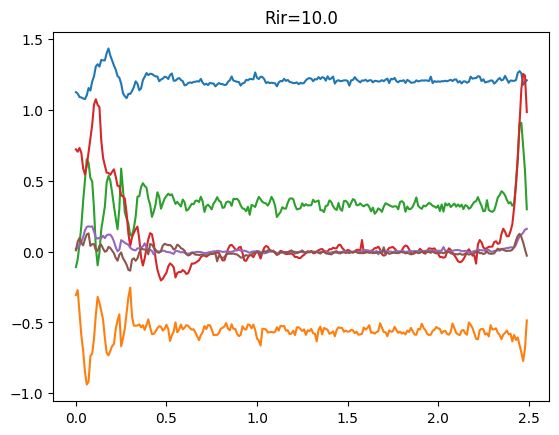

In [323]:
i = 0
plt.plot(X_windowed[i])
t = window_size / 5
tt = window_t / 5
plt.xticks(np.arange(0, window_size+1, t), np.arange(i*stride_t, i*stride_t + window_t + tt, tt));
plt.title(f'Rir={y_windowed[i]}')

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1780, 250, 6) (445, 250, 6)


In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))
mean_squared_error(y_test, y_pred)

In [184]:
regr.rvalue**2

np.float64(0.6565194283398438)

Text(0, 0.5, 'Predicted RIR')

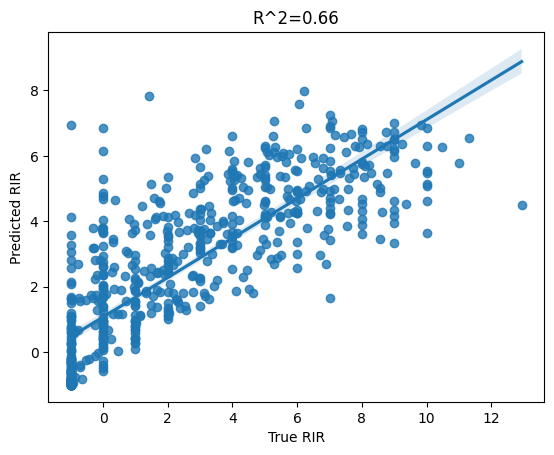

In [185]:
from scipy.stats import linregress
import seaborn as sns
regr = linregress(y_test, y_pred)
sns.regplot(x=y_test, y=y_pred)
plt.title(f'R^2={regr.rvalue**2:.2f}')
plt.xlabel('True RIR')
plt.ylabel('Predicted RIR')